# Load Data from Kaggle

In [ ]:
import numpy as np

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d rohanrao/formula-1-world-championship-1950-2020

Dataset URL: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
License(s): CC0-1.0
formula-1-world-championship-1950-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip formula-1-world-championship-1950-2020.zip

Archive:  formula-1-world-championship-1950-2020.zip
replace circuits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: circuits.csv            
replace constructor_results.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: constructor_results.csv  
replace constructor_standings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: constructor_standings.csv  
replace constructors.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: constructors.csv        
replace driver_standings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: driver_standings.csv    
replace drivers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: drivers.csv             
replace lap_times.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lap_times.csv           
replace pit_stops.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: pit_stops.csv           
replace qualifying.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: qualifying.csv          
repl

# Create Dataset

## Load data

In [ ]:
import pandas as pd
import glob
import os

def load_data(filename):
    # Attempt to load the file, assuming it's in the current directory
    try:
        return pd.read_csv(filename)
    except FileNotFoundError:
        # If not found, try a recursive search (necessary due to Colab environment uncertainty)
        csv_files = glob.glob(f'**/{filename}', recursive=True)
        if csv_files:
            return pd.read_csv(csv_files[0])
        else:
            raise FileNotFoundError(f"FATAL: {filename} not found.")

In [ ]:
# Load DataFrames
try:
    df_results = load_data('results.csv')
    df_races = load_data('races.csv')
    df_drivers = load_data('drivers.csv')
    df_constructors = load_data('constructors.csv')
    df_constructor_results = load_data('constructor_results.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the Kaggle dataset was successfully unzipped.")
    # Stop execution if data is missing
    raise

In [ ]:
df_races_filtered = df_races[
    (df_races['year'] >= 1991) & (df_races['year'] <= 2024)
].copy()

# Prepare Join Columns
# Convert all IDs to a consistent integer type before merging
df_results['raceId'] = pd.to_numeric(df_results['raceId'], errors='coerce').astype('Int64')
df_races_filtered['raceId'] = pd.to_numeric(df_races_filtered['raceId'], errors='coerce').astype('Int64')

# Also prepare driver and constructor IDs for later merges
df_drivers['driverId'] = pd.to_numeric(df_drivers['driverId'], errors='coerce').astype('Int64')
df_constructors['constructorId'] = pd.to_numeric(df_constructors['constructorId'], errors='coerce').astype('Int64')
df_results['driverId'] = pd.to_numeric(df_results['driverId'], errors='coerce').astype('Int64')
df_results['constructorId'] = pd.to_numeric(df_results['constructorId'], errors='coerce').astype('Int64')
df_constructor_results['raceId'] = pd.to_numeric(df_constructor_results['raceId'], errors='coerce').astype('Int64')
df_constructor_results['constructorId'] = pd.to_numeric(df_constructor_results['constructorId'], errors='coerce').astype('Int64')

## Merge dfs

#### added constructor results



In [ ]:
# Start with results (the most granular data). Use the original 'constructorId' for now.
df_merged = df_results.copy()
df_merged.rename(columns={
    'points': 'driver_points',          # Rename the original driver points column
    'positionText': 'finalPositionText' # Use positionText for non-numeric results (R, W, D, N)
}, inplace=True)


# --- Merge 1: with Races (on raceId) to get Season and Circuit ---
df_merged = pd.merge(
    df_merged,
    df_races[['raceId', 'year', 'circuitId', 'name','date']],
    on='raceId',
    how='left'
).rename(columns={'year': 'season', 'name': 'circuitName'})


# --- Merge 2: with Drivers (on driverId) to get names and details ---
df_merged = pd.merge(
    df_merged,
    df_drivers[['driverId', 'forename', 'surname', 'dob']],
    on='driverId',
    how='left'
).rename(columns={'forename': 'driverFirstName', 'surname': 'driverLastName'})


# --- Merge 3: with Constructors (on constructorId) to get names ---
df_merged = pd.merge(
    df_merged,
    df_constructors[['constructorId', 'name', 'nationality']],
    on='constructorId',
    how='left'
)
df_merged.rename(columns={'name': 'constructorName'}, inplace=True)

# --- Merge 5: with Constructor Results (to get team points per race) ---
df_constructor_results_merge = df_constructor_results[['raceId', 'constructorId', 'points']].rename(
    columns={'points': 'constructor_points'}
)

# Convert points to numeric, coercing errors (non-numeric results) and filling with 0.0
df_constructor_results_merge['constructor_points'] = pd.to_numeric(
    df_constructor_results_merge['constructor_points'], errors='coerce'
).fillna(0.0)

# Perform the merge onto the main dataframe
df_merged = pd.merge(
    df_merged,
    df_constructor_results_merge,
    on=['raceId', 'constructorId'], # Match both race and the team ID
    how='left'
)

# No second fillna is strictly necessary if the merge source was pre-filled,
# but keeping it ensures robustness in case a Left Join created new NaNs.
df_merged['constructor_points'] = df_merged['constructor_points'].fillna(0.0)

print(f"Total rows in final_df: {len(df_merged)}")

Total rows in final_df: 26759


In [ ]:
# Assuming your merged DataFrame is named 'df_merged'
print("--- Verification of Constructor Points Distribution ---")

# Group by the unique race and constructor combination
df_check = df_merged.groupby(['raceId', 'constructorId']).agg(
    # Get the number of rows (drivers) in the group
    driver_count=('driverId', 'count'),
    # Get the MINIMUM constructor_points assigned to a driver in this team/race
    min_team_points=('constructor_points', 'min'),
    # Get the MAXIMUM constructor_points assigned to a driver in this team/race
    max_team_points=('constructor_points', 'max')
).reset_index()

# Calculate the difference between the min and max points assigned
df_check['point_difference'] = df_check['max_team_points'] - df_check['min_team_points']

# Identify groups where the points are NOT identical (difference > 0)
df_errors = df_check[df_check['point_difference'] > 0]

# --- Reporting ---

if df_errors.empty:
    print("✅ SUCCESS: All drivers in the same race/constructor group have identical 'constructor_points'.")
else:
    print(f"🛑 WARNING: Found {len(df_errors)} race/constructor groups where 'constructor_points' differ between drivers.")
    print("Check these examples (showing raceId, constructorId, min points, max points):")
    print(df_errors[['raceId', 'constructorId', 'min_team_points', 'max_team_points']].head().to_markdown(index=False))

# Optional: Check a single known good race (e.g., raceId 18 is the 2008 Australian GP)
race_id_example = df_merged['raceId'].iloc[0] # Using the first race as an example
example_points = df_merged[df_merged['raceId'] == race_id_example][['raceId', 'constructorName', 'driverFirstName', 'constructor_points']].sort_values(by=['constructorName', 'driverFirstName']).head(4).to_markdown(index=False)
print(f"\nExample from Race ID {race_id_example}:")
print(example_points)

--- Verification of Constructor Points Distribution ---
✅ SUCCESS: All drivers in the same race/constructor group have identical 'constructor_points'.

Example from Race ID 18:
|   raceId | constructorName   | driverFirstName   |   constructor_points |
|---------:|:------------------|:------------------|---------------------:|
|       18 | BMW Sauber        | Nick              |                    8 |
|       18 | BMW Sauber        | Robert            |                    8 |
|       18 | Ferrari           | Felipe            |                    1 |
|       18 | Ferrari           | Kimi              |                    1 |


In [ ]:
df_merged.head(50) # check
#df_merged.head()
# len(df_merged)

,resultId,raceId,driverId,constructorId,number,grid,position,finalPositionText,positionOrder,driver_points,...,season,circuitId,circuitName,date,driverFirstName,driverLastName,dob,constructorName,nationality,constructor_points
0,1,18,1,1,22,1,1,1,1,10.0,...,2008,1,Australian Grand Prix,2008-03-16,Lewis,Hamilton,1985-01-07,McLaren,British,14.0
1,2,18,2,2,3,5,2,2,2,8.0,...,2008,1,Australian Grand Prix,2008-03-16,Nick,Heidfeld,1977-05-10,BMW Sauber,German,8.0
2,3,18,3,3,7,7,3,3,3,6.0,...,2008,1,Australian Grand Prix,2008-03-16,Nico,Rosberg,1985-06-27,Williams,British,9.0
3,4,18,4,4,5,11,4,4,4,5.0,...,2008,1,Australian Grand Prix,2008-03-16,Fernando,Alonso,1981-07-29,Renault,French,5.0
4,5,18,5,1,23,3,5,5,5,4.0,...,2008,1,Australian Grand Prix,2008-03-16,Heikki,Kovalainen,1981-10-19,McLaren,British,14.0
5,6,18,6,3,8,13,6,6,6,3.0,...,2008,1,Australian Grand Prix,2008-03-16,Kazuki,Nakajima,1985-01-11,Williams,British,9.0
6,7,18,7,5,14,17,7,7,7,2.0,...,2008,1,Australian Grand Prix,2008-03-16,Sébastien,Bourdais,1979-02-28,Toro Rosso,Italian,2.0
7,8,18,8,6,1,15,8,8,8,1.0,...,2008,1,Australian Grand Prix,2008-03-16,Kimi,Räikkönen,1979-10-17,Ferrari,Italian,1.0
8,9,18,9,2,4,2,\N,R,9,0.0,...,2008,1,Australian Grand Prix,2008-03-16,Robert,Kubica,1984-12-07,BMW Sauber,German,8.0
9,10,18,10,7,12,18,\N,R,10,0.0,...,2008,1,Australian Grand Prix,2008-03-16,Timo,Glock,1982-03-18,Toyota,Japanese,0.0


#### drop earlier seasons

In [ ]:
# --- Filter df_merged for Season >= 1990 ---

original_rows = len(df_merged)

# Ensure 'season' is a numeric type for comparison
df_merged['season'] = pd.to_numeric(df_merged['season'], errors='coerce')

# Drop rows where 'season' is NaN (from coerce) or less than 1990
df_merged = df_merged[df_merged['season'] >= 1990].reset_index(drop=True)

filtered_rows = len(df_merged)
dropped_rows = original_rows - filtered_rows

print(f"Original Row Count: {original_rows}")
print(f"Filtered Row Count (Season >= 1990): {filtered_rows}")
print(f"Rows Dropped (Season < 1990): {dropped_rows}")
print("✅ 'df_merged' successfully filtered for seasons starting 1990.")

Original Row Count: 26759
Filtered Row Count (Season >= 1990): 14329
Rows Dropped (Season < 1990): 12430
✅ 'df_merged' successfully filtered for seasons starting 1990.


## Teammate column

In [ ]:
# 1. Sort the DataFrame temporarily (This is essential for shift() to work correctly)
df_merged_temp = df_merged.sort_values(
    by=['season', 'raceId', 'constructorId', 'driverId']
).reset_index(drop=True).copy()

# 2. Re-run the shift operations to get the correct next and previous IDs
# Note: Ensure these temporary columns are re-calculated every time.
df_merged_temp['next_driver'] = df_merged_temp.groupby(
    ['season', 'raceId', 'constructorId']
)['driverId'].shift(-1)

df_merged_temp['prev_driver'] = df_merged_temp.groupby(
    ['season', 'raceId', 'constructorId']
)['driverId'].shift(1)

# 3. Use combine_first() to correctly assign the teammate ID.
# This works because for a pair (Driver A, Driver B):
# - Row A: 'next_driver' (B) is NOT NaN; 'prev_driver' is NaN. Result: B.
# - Row B: 'next_driver' is NaN; 'prev_driver' (A) is NOT NaN. Result: A.
# - Solo Car: Both are NaN. Result: NaN (which becomes <NA> with Int64).
df_merged_temp['teammateId'] = df_merged_temp['next_driver'].combine_first(
    df_merged_temp['prev_driver']
).astype('Int64')

# 4. Clean up and re-assign
df_merged = df_merged_temp.drop(columns=['next_driver', 'prev_driver']).copy()

print("✅ Teammate ID column successfully calculated. Solo drivers now have <NA>.")

# Display the head to verify (Solo drivers will show <NA> in the teammateId column)
df_merged.head()

✅ Teammate ID column successfully calculated. Solo drivers now have <NA>.


,resultId,raceId,driverId,constructorId,number,grid,position,finalPositionText,positionOrder,driver_points,...,circuitId,circuitName,date,driverFirstName,driverLastName,dob,constructorName,nationality,constructor_points,teammateId
0,7029,321,77,1,28,1,\N,R,18,0.0,...,33,United States Grand Prix,1990-03-11,Gerhard,Berger,1959-08-27,McLaren,British,9.0,102
1,7012,321,102,1,27,5,1,1,1,9.0,...,33,United States Grand Prix,1990-03-11,Ayrton,Senna,1960-03-21,McLaren,British,9.0,77
2,7020,321,119,3,6,12,9,9,9,0.0,...,33,United States Grand Prix,1990-03-11,Riccardo,Patrese,1954-04-17,Williams,British,4.0,123
3,7014,321,123,3,5,9,3,3,3,4.0,...,33,United States Grand Prix,1990-03-11,Thierry,Boutsen,1957-07-13,Williams,British,4.0,119
4,7028,321,95,6,2,17,\N,R,17,0.0,...,33,United States Grand Prix,1990-03-11,Nigel,Mansell,1953-08-08,Ferrari,Italian,0.0,117


In [ ]:
# 1. Check for the old error condition: driverId == teammateId
error_rows = df_merged[df_merged['driverId'] == df_merged['teammateId']]

print("--- Teammate ID Error Check ---")

if error_rows.empty:
    print("✅ SUCCESS: No rows found where driverId is equal to teammateId.")
else:
    print(f"❌ ERROR: {len(error_rows)} rows still show the driverId matching the teammateId.")
    print("Displaying 5 examples of the error:")
    print(error_rows[['driverId', 'teammateId', 'season', 'raceId', 'constructorId']].head().to_markdown(index=False))


# 2. Check for the correct behavior: single-car teams should have <NA> teammateId
# We identify single-car teams by grouping and counting.
# Solo drivers are where the team has exactly 1 driver in that race.
drivers_per_team_race = df_merged.groupby(['season', 'raceId', 'constructorId'])['driverId'].transform('count')
solo_drivers = df_merged[drivers_per_team_race == 1].copy()

# Now, check if all solo drivers have a null/NA teammateId
correct_solo_teammate = solo_drivers[solo_drivers['teammateId'].isna()]

if len(solo_drivers) == len(correct_solo_teammate):
    print("✅ SUCCESS: All solo drivers now have a <NA> teammateId.")
    print(f"Total solo driver rows checked: {len(solo_drivers)}")
else:
    print(f"⚠️ WARNING: Found {len(solo_drivers) - len(correct_solo_teammate)} solo driver rows where teammateId is NOT <NA>.")
    print("Displaying 5 examples of solo drivers with incorrect teammate ID:")
    incorrect_solo_teammate = solo_drivers[solo_drivers['teammateId'].notna()]
    print(incorrect_drivers[['driverId', 'teammateId', 'season', 'raceId', 'constructorId']].head().to_markdown(index=False))

--- Teammate ID Error Check ---
✅ SUCCESS: No rows found where driverId is equal to teammateId.
✅ SUCCESS: All solo drivers now have a <NA> teammateId.
Total solo driver rows checked: 91


In [ ]:
# --- CRITICAL BUG FIX: Drop Duplicates to prevent Teammate Self-Join ---

# The key for a single race result should be unique.
initial_row_count = len(df_merged)

df_merged.drop_duplicates(
    subset=['season', 'raceId', 'constructorId', 'driverId'],
    keep='first',
    inplace=True
)

rows_removed = initial_row_count - len(df_merged)

if rows_removed > 0:
    print(f"⚠️ WARNING: Removed {rows_removed} duplicate race results that were likely causing the teammate bug.")
else:
    print("✅ Duplicate check passed. No duplicates found.")

# Now proceed immediately with the Teammate ID calculation using the Ultimate Defensive Fix code block.

✅ Duplicate check passed. No duplicates found.


### Drop single drivers

In [ ]:
# Assuming the Teammate ID calculation (the block you provided) has just completed,
# and solo drivers have a NaN (or <NA>) value in the 'teammateId' column.

initial_row_count = len(df_merged)

# Filter the DataFrame to keep only rows where a teammateId exists (i.e., team fielded 2 cars)
df_merged = df_merged[df_merged['teammateId'].notna()].copy()

rows_removed = initial_row_count - len(df_merged)

print(f"✅ Dropped {rows_removed} solo driver rows.")
print(f"The 'df_merged' DataFrame now only contains races where a full two-car team was present.")
print(f"New row count: {len(df_merged)}")

# Re-checking the solo driver count using the 'drivers_per_team_race' method for final verification:
drivers_per_team_race = df_merged.groupby(['season', 'raceId', 'constructorId'])['driverId'].transform('count')
solo_drivers_final_check = df_merged[drivers_per_team_race == 1]

if solo_drivers_final_check.empty:
    print("✅ Final verification: No single-car teams remain in df_merged.")
else:
    print(f"❌ ERROR: Still found {len(solo_drivers_final_check)} solo driver rows after filtering.")

✅ Dropped 91 solo driver rows.
The 'df_merged' DataFrame now only contains races where a full two-car team was present.
New row count: 14238
✅ Final verification: No single-car teams remain in df_merged.


### review pairing

In [ ]:
# Ensure final_df is sorted correctly for the shift operation
# Sorting by driverId ensures stable pairing within the constructor/race group
df_merged = df_merged.sort_values(
    by=['season', 'raceId', 'constructorId', 'driverId'],
    ignore_index=True
).copy()

# Use temporary columns to hold the shifted values
df_merged['next_driver'] = df_merged.groupby(['season', 'raceId', 'constructorId'])['driverId'].shift(-1)
df_merged['prev_driver'] = df_merged.groupby(['season', 'raceId', 'constructorId'])['driverId'].shift(1)

# Combine the shifted columns:
# For the first driver, 'prev_driver' is NaN, so it takes 'next_driver' (the teammate).
# For the second driver, 'next_driver' is NaN, so it takes 'prev_driver' (the teammate).
# For a solo car, both will be NaN, resulting in NaN (correctly indicating no teammate).
df_merged['teammateId'] = df_merged['next_driver'].combine_first(df_merged['prev_driver'])

# Convert teammateId to Integer (coercing NaNs to the nullable Integer type)
df_merged['teammateId'] = df_merged['teammateId'].astype('Int64')

# Drop the temporary shift columns
df_merged.drop(columns=['next_driver', 'prev_driver'], inplace=True)

print("✅ Teammate ID successfully calculated using the defensive fix.")
df_merged.head()


✅ Teammate ID successfully calculated using the defensive fix.


,resultId,raceId,driverId,constructorId,number,grid,position,finalPositionText,positionOrder,driver_points,...,circuitId,circuitName,date,driverFirstName,driverLastName,dob,constructorName,nationality,constructor_points,teammateId
0,7029,321,77,1,28,1,\N,R,18,0.0,...,33,United States Grand Prix,1990-03-11,Gerhard,Berger,1959-08-27,McLaren,British,9.0,102
1,7012,321,102,1,27,5,1,1,1,9.0,...,33,United States Grand Prix,1990-03-11,Ayrton,Senna,1960-03-21,McLaren,British,9.0,77
2,7020,321,119,3,6,12,9,9,9,0.0,...,33,United States Grand Prix,1990-03-11,Riccardo,Patrese,1954-04-17,Williams,British,4.0,123
3,7014,321,123,3,5,9,3,3,3,4.0,...,33,United States Grand Prix,1990-03-11,Thierry,Boutsen,1957-07-13,Williams,British,4.0,119
4,7028,321,95,6,2,17,\N,R,17,0.0,...,33,United States Grand Prix,1990-03-11,Nigel,Mansell,1953-08-08,Ferrari,Italian,0.0,117


# final_df

In [ ]:
# 5. Final Column Selection and Renaming (Updated to include teammateId)

final_df = df_merged.rename(columns={
    'forename': 'driverFirstName',
    'surname': 'driverLastName',
    'positionOrder': 'finalPosition',
}).loc[:, [
    'raceId',
    'season',
    'date',
    'circuitId',
    'circuitName',
    'constructorId',
    'constructorName',
    'driverId',
    'driverFirstName',
    'driverLastName',
    'nationality',
    'finalPosition',
    'finalPositionText',
    'driver_points',
    #'totalPitStopDuration_ms',
    'teammateId',
    'constructor_points'
]]


# Final check of the sorted data
print("\nFinal Sorted DataFrame with teammateId (Head):")
print(final_df[['season', 'raceId', 'driverFirstName', 'constructorName', 'teammateId']].head(10).to_markdown(index=False))


Final Sorted DataFrame with teammateId (Head):
|   season |   raceId | driverFirstName   | constructorName   |   teammateId |
|---------:|---------:|:------------------|:------------------|-------------:|
|     1990 |      321 | Gerhard           | McLaren           |          102 |
|     1990 |      321 | Ayrton            | McLaren           |           77 |
|     1990 |      321 | Riccardo          | Williams          |          123 |
|     1990 |      321 | Thierry           | Williams          |          119 |
|     1990 |      321 | Nigel             | Ferrari           |          117 |
|     1990 |      321 | Alain             | Ferrari           |           95 |
|     1990 |      321 | Pierluigi         | Minardi           |          147 |
|     1990 |      321 | Paolo             | Minardi           |           94 |
|     1990 |      321 | Michele           | Arrows            |          146 |
|     1990 |      321 | Bernd             | Arrows            |          105 |


In [ ]:
print(len(final_df)) # check

14238


# Constructor linage mapping

In [ ]:
row_count = len(final_df)

print(f"Row count of final_df: {row_count}")

distinct_constructors = final_df['constructorName'].dropna().unique()
distinct_constructorID = final_df['constructorId'].dropna().unique()

print(distinct_constructors)
#print(distinct_constructorID)

Row count of final_df: 14238
['McLaren' 'Williams' 'Ferrari' 'Minardi' 'Arrows' 'Benetton' 'Tyrrell'
 'Ligier' 'Team Lotus' 'Larrousse' 'Brabham' 'Dallara' 'AGS'
 'Leyton House' 'Euro Brun' 'Onyx' 'Jordan' 'Footwork' 'Lambo' 'Lola'
 'Fondmetal' 'March' 'Andrea Moda' 'Sauber' 'Pacific' 'Simtek' 'Forti'
 'Prost' 'Stewart' 'BAR' 'Jaguar' 'Renault' 'Toyota' 'Red Bull'
 'BMW Sauber' 'Toro Rosso' 'Super Aguri' 'Honda' 'MF1' 'Spyker MF1'
 'Spyker' 'Force India' 'Brawn' 'Mercedes' 'HRT' 'Virgin' 'Lotus'
 'Marussia' 'Caterham' 'Lotus F1' 'Manor Marussia' 'Haas F1 Team'
 'Alfa Romeo' 'Racing Point' 'AlphaTauri' 'Aston Martin' 'Alpine F1 Team'
 'RB F1 Team']


In [ ]:
df_merged.constructorId.unique()

<IntegerArray>
[  1,   3,   6,  18,  21,  22,  25,  27,  32,  33,  34,  35,  39,  41,  44,
  46,  17,  29,  40,  26,  36,  37,  38,  15,  30,  31,  28,  20,  24,  16,
  19,   4,   7,   9,   2,   5,   8,  11,  13,  14,  12,  10,  23, 131, 164,
 166, 205, 206, 207, 208, 209, 210,  51, 211, 213, 117, 214, 215]
Length: 58, dtype: Int64

In [ ]:
OFFSET = 250

team_linage_map = {
    # 1 - SCUDERIA FERRARI
    'Ferrari': 1,

    # 2 - WILLIAMS RACING
    'Williams': 2,

    # 3 - MCLAREN
    'McLaren': 3,

    # 4 - RED BULL RACING LINE
    'Stewart': 4 + OFFSET,
    'Jaguar': 4 + OFFSET,
    'Red Bull': 4 + OFFSET,
    'Red Bull Racing': 4 + OFFSET,

    # 5 - RB (VISA Cash App) LINE
    'Minardi': 5 + OFFSET,
    'Toro Rosso': 5 + OFFSET,
    'AlphaTauri': 5 + OFFSET,
    'RB': 5 + OFFSET,
    'RB F1 Team': 5 + OFFSET,          # ### NEW/FIXED (Crucial for 2024)

    # 6 - ASTON MARTIN LINE
    'Jordan': 6 + OFFSET,
    'MF1': 6 + OFFSET,
    'Spyker': 6 + OFFSET,
    'Force India': 6 + OFFSET,
    'Racing Point': 6 + OFFSET,
    'Aston Martin': 6 + OFFSET,

    # 7 - MERCEDES LINE
    'BAR': 7 + OFFSET,
    'British American Racing': 7 + OFFSET,
    'Honda': 7 + OFFSET,
    'Honda Racing F1 Team': 7 + OFFSET,
    'Brawn': 7 + OFFSET,
    'Mercedes': 7 + OFFSET,

    # 8 - ALPINE/RENAULT LINE
    'Toleman': 8 + OFFSET,
    'Benetton': 8 + OFFSET,
    'Renault': 8 + OFFSET,
    'Lotus F1': 8 + OFFSET,            # (This is the 2012-2015 Enstone team)
    'Alpine': 8 + OFFSET,
    'Alpine F1 Team': 8 + OFFSET,      # ### NEW/FIXED (Crucial for Gasly/Ocon)

    # 9 - SAUBER/KICK LINE
    'Sauber': 9 + OFFSET,
    'BMW Sauber': 9 + OFFSET,
    'Alfa Romeo': 9 + OFFSET,
    'Stake': 9 + OFFSET,
    'Kick Sauber': 9 + OFFSET,
    'Stake F1 Team Kick Sauber': 9 + OFFSET,

    # 10 - HAAS
    'Haas': 10 + OFFSET,
    'Haas F1 Team': 10 + OFFSET,       # ### NEW/FIXED

    # 11 - TYRRELL
    'Tyrrell': 11 + OFFSET,

    # 13 - MARCH/LEYTON HOUSE LINE
    'March': 13 + OFFSET,
    'Leyton House': 13 + OFFSET,

    # OTHER INDEPENDENTS (To prevent "False Positive" moves if they just changed names)
    'Lotus': 14 + OFFSET,              # (2010-2011 Team that became Caterham)
    'Caterham': 14 + OFFSET,

    'Virgin': 15 + OFFSET,
    'Marussia': 15 + OFFSET,
    'Manor Marussia': 15 + OFFSET,
}

constructor_name_column = 'constructorName'

# Update final_df
# 1. Apply the map
final_df['reference_constructorId'] = final_df[constructor_name_column].map(team_linage_map)

# 2. Fill NaN values (teams not in our map) with their original ID
final_df['reference_constructorId'] = final_df['reference_constructorId'].fillna(final_df['constructorId'])

# 3. Ensure integer type
final_df['reference_constructorId'] = final_df['reference_constructorId'].astype(int)

# --- VERIFICATION ---
# Check if the 2024 teams are now correct
print("2024 Team IDs Check:")
print(final_df[final_df['season'] == 2024][[constructor_name_column, 'reference_constructorId']].drop_duplicates())

2024 Team IDs Check:
      constructorName  reference_constructorId
13760         McLaren                        3
13762        Williams                        2
13764         Ferrari                        1
13766        Red Bull                      254
13768          Sauber                      259
13770    Aston Martin                      256
13772        Mercedes                      257
13774    Haas F1 Team                      260
13776  Alpine F1 Team                      258
13778      RB F1 Team                      255


# Movers vs Stayers

In [ ]:
[i for i in list(final_df.columns) if "points" in i]

['driver_points', 'constructor_points']

In [ ]:
final_df[["constructorName", "driverLastName", "driver_points", "constructor_points"]]

,constructorName,driverLastName,driver_points,constructor_points
0,McLaren,Berger,0.0,9.0
1,McLaren,Senna,9.0,9.0
2,Williams,Patrese,0.0,4.0
3,Williams,Boutsen,4.0,4.0
4,Ferrari,Mansell,0.0,0.0
...,...,...,...,...
14233,Haas F1 Team,Magnussen,0.0,4.0
14234,Alpine F1 Team,Gasly,6.0,6.0
14235,Alpine F1 Team,Doohan,0.0,6.0
14236,RB F1 Team,Tsunoda,0.0,0.0


In [ ]:
final_df.describe()

,raceId,season,circuitId,constructorId,driverId,finalPosition,driver_points,teammateId,constructor_points,reference_constructorId
count,14238.0,14238.000000,14238.000000,14238.0,14238.0,14238.000000,14238.000000,14238.0,14238.000000,14238.000000
mean,525.204523,2007.097486,18.903217,40.42815,272.550077,11.852297,2.897317,272.550077,5.873016,154.434190
std,406.057528,10.408435,19.040938,64.447188,355.875718,6.878543,5.452399,355.875718,9.737838,121.707994
min,1.0,1990.000000,1.000000,1.0,1.0,1.000000,0.000000,1.0,0.000000,1.000000
25%,171.0,1998.000000,7.000000,5.0,20.0,6.000000,0.000000,20.0,0.000000,3.000000
50%,314.0,2008.000000,13.000000,15.0,65.0,12.000000,0.000000,65.0,1.000000,255.000000
75%,960.0,2016.000000,22.000000,29.0,815.0,17.000000,4.000000,815.0,8.000000,258.000000
max,1144.0,2024.000000,80.000000,215.0,862.0,35.000000,50.000000,862.0,66.000000,265.000000


In [ ]:
final_df

,raceId,season,date,circuitId,circuitName,constructorId,constructorName,driverId,driverFirstName,driverLastName,nationality,finalPosition,finalPositionText,driver_points,teammateId,constructor_points,reference_constructorId
0,321,1990,1990-03-11,33,United States Grand Prix,1,McLaren,77,Gerhard,Berger,British,18,R,0.0,102,9.0,3
1,321,1990,1990-03-11,33,United States Grand Prix,1,McLaren,102,Ayrton,Senna,British,1,1,9.0,77,9.0,3
2,321,1990,1990-03-11,33,United States Grand Prix,3,Williams,119,Riccardo,Patrese,British,9,9,0.0,123,4.0,2
3,321,1990,1990-03-11,33,United States Grand Prix,3,Williams,123,Thierry,Boutsen,British,3,3,4.0,119,4.0,2
4,321,1990,1990-03-11,33,United States Grand Prix,6,Ferrari,95,Nigel,Mansell,Italian,17,R,0.0,117,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14233,1144,2024,2024-12-08,24,Abu Dhabi Grand Prix,210,Haas F1 Team,825,Kevin,Magnussen,American,16,16,0.0,807,4.0,260
14234,1144,2024,2024-12-08,24,Abu Dhabi Grand Prix,214,Alpine F1 Team,842,Pierre,Gasly,French,7,7,6.0,862,6.0,258
14235,1144,2024,2024-12-08,24,Abu Dhabi Grand Prix,214,Alpine F1 Team,862,Jack,Doohan,French,15,15,0.0,842,6.0,258
14236,1144,2024,2024-12-08,24,Abu Dhabi Grand Prix,215,RB F1 Team,852,Yuki,Tsunoda,Italian,12,12,0.0,859,0.0,255


In [ ]:
final_df = final_df.sort_values(
    by=['driverId', 'season', 'raceId'],
    ignore_index=True
).copy()

final_df.tail()

,raceId,season,date,circuitId,circuitName,constructorId,constructorName,driverId,driverFirstName,driverLastName,nationality,finalPosition,finalPositionText,driver_points,teammateId,constructor_points,reference_constructorId
14233,1141,2024,2024-11-03,18,São Paulo Grand Prix,3,Williams,861,Franco,Colapinto,British,17,R,0.0,848,0.0,2
14234,1142,2024,2024-11-23,80,Las Vegas Grand Prix,3,Williams,861,Franco,Colapinto,British,14,14,0.0,848,0.0,2
14235,1143,2024,2024-12-01,78,Qatar Grand Prix,3,Williams,861,Franco,Colapinto,British,19,R,0.0,848,0.0,2
14236,1144,2024,2024-12-08,24,Abu Dhabi Grand Prix,3,Williams,861,Franco,Colapinto,British,19,R,0.0,848,0.0,2
14237,1144,2024,2024-12-08,24,Abu Dhabi Grand Prix,214,Alpine F1 Team,862,Jack,Doohan,French,15,15,0.0,842,6.0,258


## Mover vs. Stayer

In [ ]:
# 2. Calculate the previous team for every specific race
final_df['prev_constructor_id'] = final_df.groupby('driverId')['reference_constructorId'].shift(1)

# 3. Create the Move Flag
# It is a move if:
# A) The driver has a previous race history (prev_constructor_id is not NaN)
# B) The current team is different from the previous race's team
final_df['moved_team'] = np.where(
    (final_df['prev_constructor_id'].notna()) &
    (final_df['reference_constructorId'] != final_df['prev_constructor_id']),
    1,
    0
)

# Optional: Clean up the helper column if you don't need it
final_df.drop(columns=['prev_constructor_id'], inplace=True)


print(f"✅ Race-by-race team movement flag set. Total moves found: {final_df['moved_team'].sum()}")

✅ Race-by-race team movement flag set. Total moves found: 288


In [ ]:
final_df['moved_team'].sum()

np.int64(288)

### Remove non-continous movers

In [ ]:
# Ensure date is properly formatted
final_df['date'] = pd.to_datetime(final_df['date'])

# Ensure strict sorting first
final_df = final_df.sort_values(by=['driverId', 'date']).copy()

# 1. Calculate the gap in days from the previous race specific to that driver
final_df['prev_race_date'] = final_df.groupby('driverId')['date'].shift(1)
final_df['days_since_last_race'] = (final_df['date'] - final_df['prev_race_date']).dt.days

# 2. Define a "Continuity Threshold"
# 240 days covers standard off-seasons and the 2020 Covid delay,
# but excludes drivers who missed a full season (365+ days).
GAP_THRESHOLD = 240

# 3. Identify Non-Continuous Stints
# If the gap is too large, we flag it.
final_df['is_return_after_break'] = np.where(final_df['days_since_last_race'] > GAP_THRESHOLD, 1, 0)

# If a driver comes back after 2 years, we reset their "Mover" status so they don't skew the result.
final_df.loc[final_df['is_return_after_break'] == 1, 'moved_team'] = 0
# Note: You might also want to reset the 'stint_race_count' or 'is_race_1' dummies for these cases
# to avoid treating a Return as a standard "New Hire".

print(f"Found {final_df['is_return_after_break'].sum()} instances of drivers returning after a long break.")

Found 99 instances of drivers returning after a long break.


In [ ]:
final_df['prev_race_date'] = final_df.groupby('driverId')['date'].shift(1)
final_df['days_since_last_race'] = (final_df['date'] - final_df['prev_race_date']).dt.days

# B. Identify Return Events (> 240 days gap)
# Note: NaN (Debut) is not > 240, so true rookies are kept.
final_df['is_return_event'] = np.where(final_df['days_since_last_race'] > GAP_THRESHOLD, 1, 0)

# C. Recalculate Stint IDs (Safety measure to ensure they are unique per driver)
# New stint if team changes OR if it is a Return Event
final_df['team_shift'] = (final_df['reference_constructorId'] != final_df.groupby('driverId')['reference_constructorId'].shift(1))
final_df['is_new_stint'] = (final_df['team_shift']) | (final_df['is_return_event'] == 1)
final_df['stint_id_unique'] = final_df.groupby('driverId')['is_new_stint'].cumsum()

# D. Propagate Pollution Flag
# If a stint STARTS with a return event, flag the WHOLE stint
final_df['stint_is_polluted'] = final_df.groupby(['driverId', 'stint_id_unique'])['is_return_event'].transform('max')

# E. Create Clean Dataset
final_df = final_df[final_df['stint_is_polluted'] == 0].copy()

In [ ]:
final_df['moved_team'].sum()

np.int64(209)

### Calculate tenure

In [ ]:
# Ensure date is properly formatted
final_df['date'] = pd.to_datetime(final_df['date'])

# 1. Identify start of a new stint
# We flag True if the current team is different from the previous race's team.
# We fillna(-1) so the driver's debut counts as a new stint.
final_df['is_new_stint'] = (
    final_df['reference_constructorId'] !=
    final_df.groupby('driverId')['reference_constructorId'].shift(1).fillna(-1)
)

# 2. Generate a Unique Stint ID
# The ID increments every time 'is_new_stint' is True for that driver.
# Example: Stint 1 (Team A) -> Stint 2 (Team B) -> Stint 3 (Team A again)
final_df['stint_id'] = final_df.groupby('driverId')['is_new_stint'].cumsum()

# 3. Broadcast the Stint Start Date to every row in that stint
final_df['stint_start_date'] = final_df.groupby(['driverId', 'stint_id'])['date'].transform('min')

# 4. Calculate Tenure in Days
final_df['tenure_days'] = (final_df['date'] - final_df['stint_start_date']).dt.days

# Optional clean up
#final_df.drop(columns=['is_new_stint', 'stint_id', 'stint_start_date'], inplace=True)

In [ ]:
# Check if any driver in the specific team/race combination is a Mover
final_df['team_has_mover'] = final_df.groupby(['raceId', 'reference_constructorId'])['moved_team'].transform('max')

# A Stayer is someone who didn't move, but is in a team where someone else did
final_df['stayer'] = np.where(
    (final_df['team_has_mover'] == 1) & (final_df['moved_team'] == 0),
    1,
    0
)

final_df.drop(columns=['team_has_mover'], inplace=True)

### Map points to modern scale

In [ ]:
# 1. Define the point mapping
MODERN_POINTS = {
    1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1
}

def calculate_normalized_race_points(position):
    """
    Calculates points based on the modern system (25-18-15...),
    returning 0 for raced but non-scoring positions.
    """
    if pd.isna(position) or str(position).strip().lower() in ['nan', 'n/a', 'na']:
        # Return 0 for NaNs (e.g., non-participation)
        return 0
    try:
        # Get the points from the map, default to 0 if not in the map (e.g., P11)
        return MODERN_POINTS.get(int(position), 0)
    except (ValueError, TypeError):
        # This handles non-numeric values like 'R' (Retired)
        return 0

# 2. Apply the function to 'finalPosition'
final_df['normalized_points'] = final_df['finalPosition'].apply(calculate_normalized_race_points)

### Export dataset

In [ ]:
final_df.shape

(12350, 31)

In [ ]:
for col in final_df.columns:
    print(col)

raceId
season
date
circuitId
circuitName
constructorId
constructorName
driverId
driverFirstName
driverLastName
nationality
finalPosition
finalPositionText
driver_points
teammateId
constructor_points
reference_constructorId
moved_team
prev_race_date
days_since_last_race
is_return_after_break
is_return_event
team_shift
is_new_stint
stint_id_unique
stint_is_polluted
stint_id
stint_start_date
tenure_days
stayer
normalized_points


In [ ]:
final_df = final_df.drop(columns=[
    'finalPosition',
    'finalPositionText',
    'driver_points',
    'constructor_points',
    'constructorId'
    ]).sort_values(["season", "raceId", "reference_constructorId"])

In [1]:
# This is the file we export to sheets and manually label each move

final_df.to_csv('f1_data_full.csv', index=False)

NameError: name 'final_df' is not defined

# Playing with Analyses

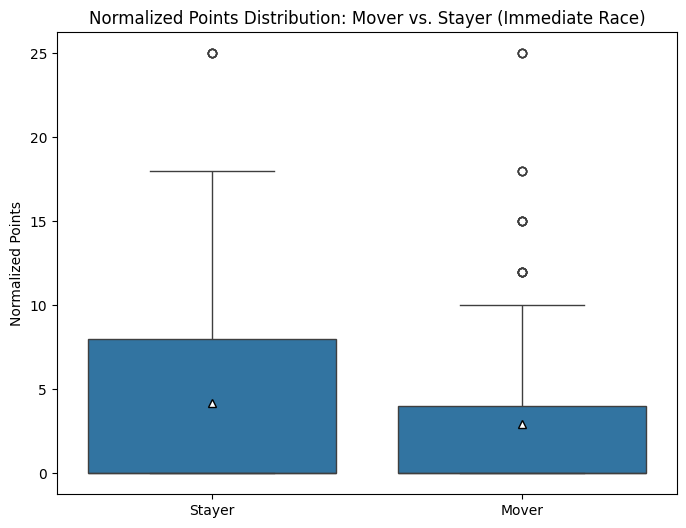

In [ ]:
# Filter data for Movers and Stayers only
plot_df = final_df[
    (final_df['moved_team'] == 1) |
    (final_df['stayer'] == 1)
].copy()

# Create descriptive labels
plot_df['Status'] = np.where(plot_df['moved_team'] == 1, 'Mover', 'Stayer')

plt.figure(figsize=(8, 6))

# Boxplot with means (showmeans=True adds the triangle for the average)
sns.boxplot(
    data=plot_df,
    x='Status',
    y='normalized_points',
    showmeans=True,
    meanprops={"marker": "^", "markerfacecolor": "white", "markeredgecolor": "black"}
)

plt.title('Normalized Points Distribution: Mover vs. Stayer (Immediate Race)')
plt.ylabel('Normalized Points')
plt.xlabel('')
plt.show()

In [ ]:
from scipy import stats

# 1. Isolate the two groups
movers_points = final_df.loc[final_df['moved_team'] == 1, 'normalized_points']
stayers_points = final_df.loc[final_df['stayer'] == 1, 'normalized_points']

t_stat, p_val = stats.ttest_ind(movers_points, stayers_points, equal_var=True)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4g}") # .4g handles very small scientific notation

T-statistic: -1.9725
P-value: 0.04931


**T-Test is bareley significant, but we might actually have to use equal_var=FalSe here**

In [ ]:
!pip install stargazer -q

In [ ]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import display, HTML

# 1. Create a binary variable indicating movers vs stayers
# Assuming 'moved_team' == 1 for movers, 0 otherwise
final_df['is_mover'] = final_df['moved_team']

# 2. Define dependent and independent variables
X = sm.add_constant(final_df['is_mover'])  # Adds the intercept
y = final_df['normalized_points']

# 3. Fit OLS regression
model = sm.OLS(y, X).fit()

# 4. Print summary with Stargazer
stargazer = Stargazer([model])

display(HTML(stargazer.render_html()))

**HUrray!!! We have significancte for all explanatory variables (R-Squared is very low thoug)**

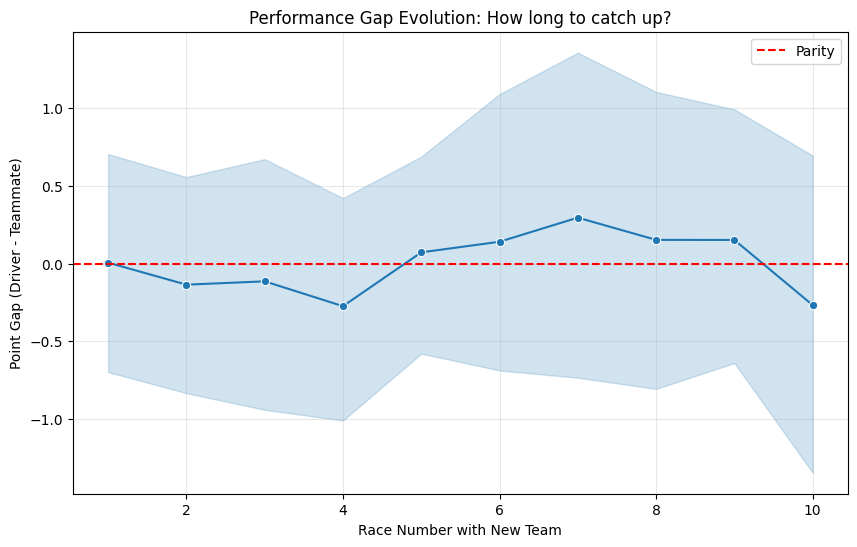

In [ ]:
# 1. Create a Race Counter per Stint
# (Assumes you ran the stint_id logic from earlier)
final_df['stint_race_count'] = final_df.groupby(['driverId', 'stint_id']).cumcount() + 1

# 2. Re-create the Pairings for the first 10 races, not just Race 1
# We self-join on Race/Team again, but this time we don't filter for moved_team==1
# We filter for stint_race_count <= 10
stint_df = final_df[final_df['stint_race_count'] <= 10].copy()

# Create pairs
pairs_evolution = stint_df.merge(
    stint_df[['raceId', 'reference_constructorId', 'driverId', 'normalized_points', 'stint_race_count']],
    on=['raceId', 'reference_constructorId'],
    suffixes=('', '_teammate')
)

# Filter: Remove self-matches and keep only pairs where ONE is the new guy (low count) and ONE is the veteran
# We define "Veteran" here as someone who has been there longer than the current race count of the new guy
# But for simplicity in your 'Natural Experiment', let's stick to the specific pairs we identified as Movers/Stayers earlier
# and track them forward.

# Simpler Logic: Just plot the gap based on the Mover's stint count
# We compare Driver A (at Stint Count X) vs Driver B (Teammate)
pairs_evolution = pairs_evolution[pairs_evolution['driverId'] != pairs_evolution['driverId_teammate']]

# Calculate Gap
pairs_evolution['gap'] = pairs_evolution['normalized_points'] - pairs_evolution['normalized_points_teammate']

# 3. Visualize
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=pairs_evolution,
    x='stint_race_count',
    y='gap',
    errorbar='ci', # Shows the confidence interval
    marker='o'
)

plt.axhline(0, color='red', linestyle='--', label='Parity')
plt.title('Performance Gap Evolution: How long to catch up?')
plt.xlabel('Race Number with New Team')
plt.ylabel('Point Gap (Driver - Teammate)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Running Fixed Effects Regression...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 260, but rank is 52
  warnings.warn('covariance of constraints does not have full '


                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            12.5375      1.310      9.572      0.000       9.970      15.105
C(driverId)[T.2]                     -4.3146      1.176     -3.668      0.000      -6.620      -2.009
C(driverId)[T.3]                     -4.7997      0.415    -11.568      0.000      -5.613      -3.987
C(driverId)[T.4]                     -3.8504      0.958     -4.021      0.000      -5.727      -1.974
C(driverId)[T.5]                     -6.2859      0.945     -6.653      0.000      -8.138      -4.434
C(driverId)[T.6]                    -10.0142      1.298     -7.713      0.000     -12.559      -7.470
C(driverId)[T.7]                     -6.3896      1.267     -5.043      0.000      -8.873      -3.906
C(driverId)[T.8]                     -4.5292      1.044     -4.337      0.000     

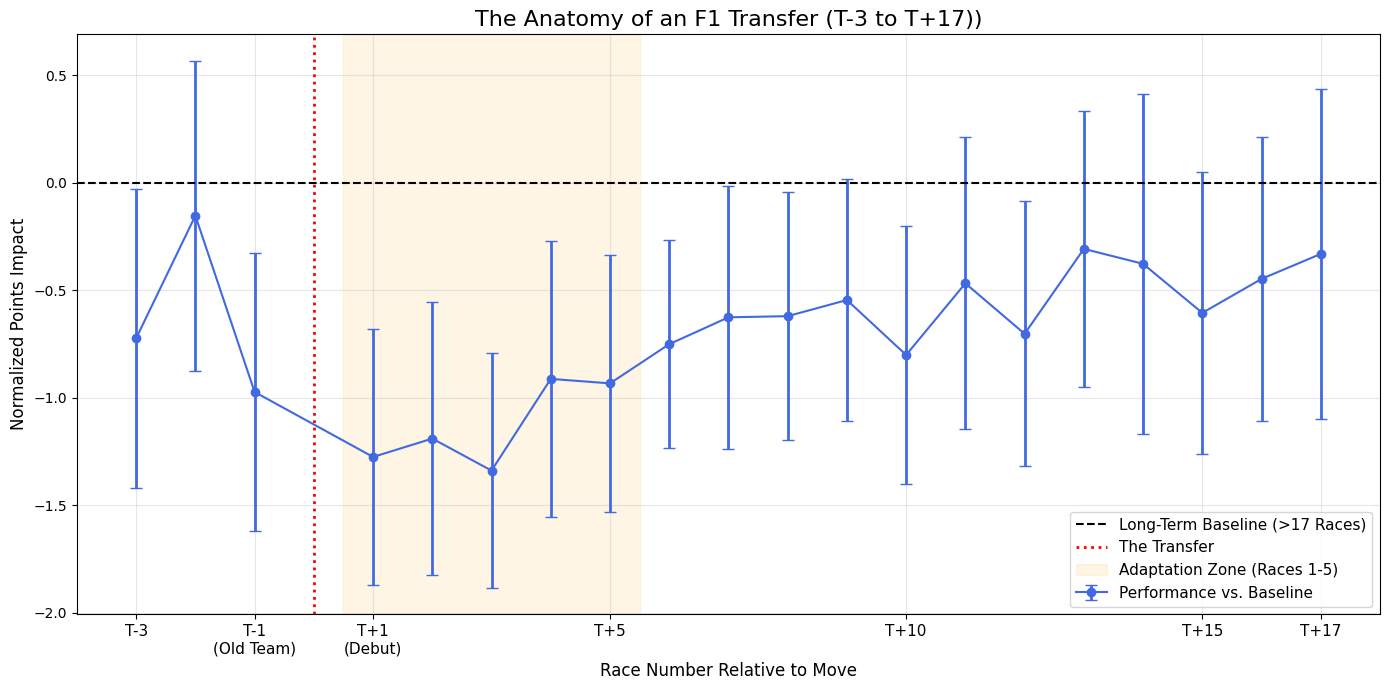

In [ ]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 1. Load Data & Basic Setup
df = final_df.copy()

# Ensure correct types
df['date'] = pd.to_datetime(df['date'])
df['driverId'] = df['driverId'].astype(int)
df['reference_constructorId'] = df['reference_constructorId'].astype(int)
df['normalized_points'] = df['normalized_points'].fillna(0).astype(float)

# Sort strictly for time calculations
df = df.sort_values(by=['driverId', 'date']).reset_index(drop=True)


# A. Calculate Tenure Counter (1, 2, 3...)
df['stint_race_count'] = df.groupby(['driverId', 'stint_id_unique']).cumcount() + 1

# B. Calculate Teammate Points (Control Variable)
# Sum of all points for that team-race, minus the driver's own points
team_points_sum = df.groupby(['raceId', 'reference_constructorId'])['normalized_points'].transform('sum')
df['teammate_points'] = team_points_sum - df['normalized_points']

# C. Create Event Study Dummies (The "Mover" Variables)
# Post-Move: T1 to T17
post_move_vars = []
for i in range(1, 18):
    col = f'is_race_{i}'
    df[col] = (df['stint_race_count'] == i).astype(int)
    post_move_vars.append(col)

# Pre-Move: T-1 to T-3
# We look ahead. If the row i steps ahead is 'Race 1', then I am currently at T-i
pre_move_vars = []
for i in [3, 2, 1]:
    col = f'is_race_minus_{i}'
    # Shift(-i) looks into the future. If future is Race 1, current is Minus i
    # We use 'stint_race_count' == 1 to identify the move
    future_is_move = df.groupby('driverId')['stint_race_count'].shift(-i) == 1
    df[col] = future_is_move.fillna(False).astype(int)
    pre_move_vars.append(col)

# ---------------------------------------------------------
# 4. REGRESSION
# ---------------------------------------------------------

# Variables: Pre-Move + Post-Move
# Baseline is automatically everything else (Tenure > 17)
all_event_vars = pre_move_vars + post_move_vars
formula = f"normalized_points ~ {' + '.join(all_event_vars)} + teammate_points + C(driverId) + C(reference_constructorId)"

print("Running Fixed Effects Regression...")
model = smf.ols(formula=formula, data=df)
# Cluster errors by Driver to account for serial correlation
result = model.fit(cov_type='cluster', cov_kwds={'groups': df['driverId']})
print(result.summary().tables[1])

# ---------------------------------------------------------
# 5. VISUALIZATION (Robust Array Method)
# ---------------------------------------------------------

# Extract data strictly as numpy arrays to prevent plotting errors
params = result.params.loc[all_event_vars].values
conf_ints = result.conf_int().loc[all_event_vars].values
yerr = conf_ints[:, 1] - params # Distance from mean to upper bound

# Define X-Axis: -3, -2, -1, 1, 2... 17
x_coords = np.array([-3, -2, -1] + list(range(1, 18)))

plt.figure(figsize=(14, 7))

# 1. The Data Points
plt.errorbar(
    x=x_coords,
    y=params,
    yerr=yerr,
    fmt='-o',
    color='royalblue',
    ecolor='royalblue',
    elinewidth=2,
    capsize=4,
    markersize=6,
    label='Performance vs. Baseline'
)

# 2. Reference Lines & Zones
plt.axhline(0, color='black', linewidth=1.5, linestyle='--', label='Long-Term Baseline (>17 Races)')
plt.axvline(0, color='red', linewidth=2, linestyle=':', label='The Transfer')
plt.axvspan(0.5, 5.5, color='orange', alpha=0.1, label='Adaptation Zone (Races 1-5)')

# 3. Formatting
plt.title('The Anatomy of an F1 Transfer (T-3 to T+17))', fontsize=16)
plt.xlabel('Race Number Relative to Move', fontsize=12)
plt.ylabel('Normalized Points Impact', fontsize=12)

# Custom X-Ticks for readability
tick_locs = [-3, -1, 1, 5, 10, 15, 17]
tick_labels = ['T-3', 'T-1\n(Old Team)', 'T+1\n(Debut)', 'T+5', 'T+10', 'T+15', 'T+17']
plt.xticks(tick_locs, tick_labels, fontsize=11)

plt.legend(loc='lower right', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save and Show
#bplt.savefig('anatomy_of_a_move_clean.png')  # Uncomment this if you want to export a png for your report
plt.show()

In [ ]:
import numpy as np

# 1. Create Stint Counter (Time since move)
# We group by the 'stint_id' we created earlier to count 1, 2, 3...
final_df['stint_race_count'] = final_df.groupby(['driverId', 'stint_id']).cumcount() + 1

# 2. Log Transformation (The independent variable of interest)
final_df['log_tenure'] = np.log(final_df['stint_race_count'])

# 3. Create Event Dummies (for your future T-1, T-2 analysis)
# These are binary flags for "Is this the 1st race?", "Is this the 2nd race?"
final_df['is_race_1'] = (final_df['stint_race_count'] == 1).astype(int)
final_df['is_race_2'] = (final_df['stint_race_count'] == 2).astype(int)
final_df['is_race_3'] = (final_df['stint_race_count'] == 3).astype(int)

# 4. Get Teammate Points (The control for Car Performance)
# We aggregate to finding the MAX points scored by any other driver in the same team/race
# This proxies the "Maximum Potential" of the car that day.
def get_teammate_score(x):
    # This creates a mapping of race+team -> max_points
    return x.groupby(['raceId', 'reference_constructorId'])['normalized_points'].transform(
        lambda s: s.nlargest(2).min() if len(s) > 1 else 0 # Takes the 2nd highest score (the teammate) or 0 if solo
    )

# Note: A simpler approximate vectorised approach for 2-driver teams:
# Sum of team points minus driver points = teammate points
team_total = final_df.groupby(['raceId', 'reference_constructorId'])['normalized_points'].transform('sum')
final_df['teammate_points'] = team_total - final_df['normalized_points']

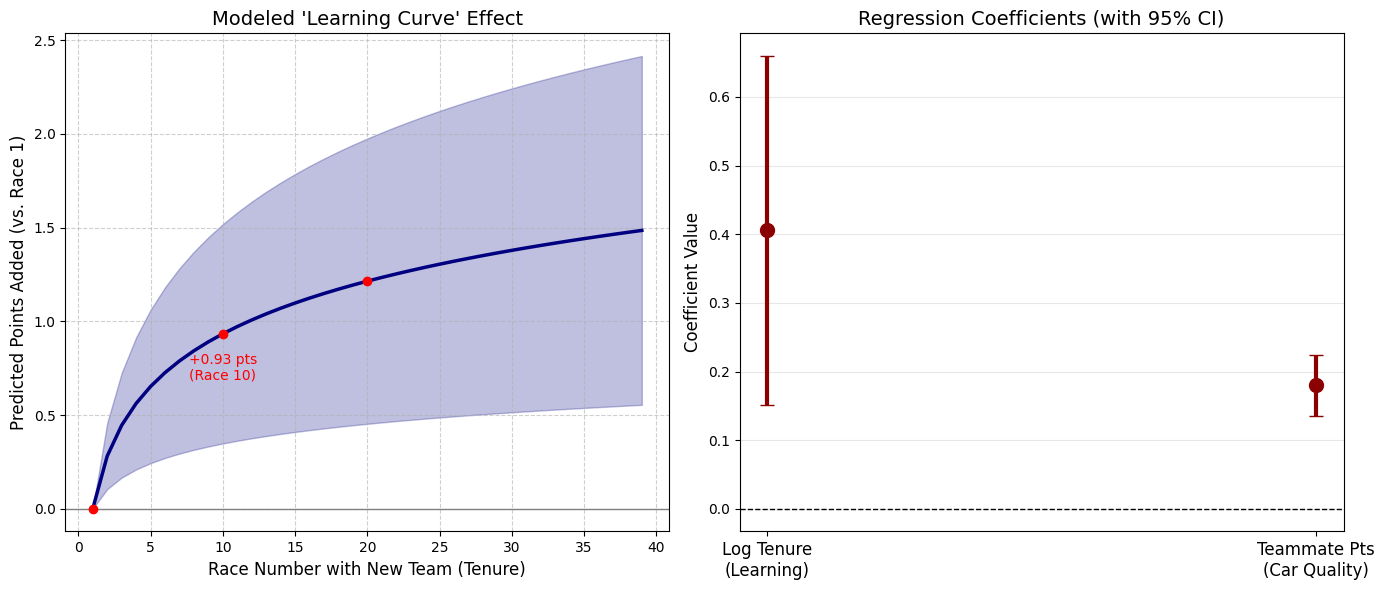

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns

# Re-run regression to ensure we have the 'result' object and consistent data
# We assume final_df is in the environment from previous turns
# But we need to make sure the columns are cast correctly again if the cell wasn't persistent (safeguard)

cols_to_use = ['driverId', 'reference_constructorId', 'normalized_points', 'teammate_points', 'log_tenure']
# Dropna to match the model data
reg_df = final_df.dropna(subset=cols_to_use).copy()

# Ensure types
reg_df['driverId'] = reg_df['driverId'].astype(int)
reg_df['reference_constructorId'] = reg_df['reference_constructorId'].astype(int)
reg_df['normalized_points'] = reg_df['normalized_points'].astype(float)
reg_df['teammate_points'] = reg_df['teammate_points'].astype(float)
reg_df['log_tenure'] = reg_df['log_tenure'].astype(float)

# Fit model
formula = 'normalized_points ~ log_tenure + teammate_points + C(driverId) + C(reference_constructorId)'
model = smf.ols(formula=formula, data=reg_df)
# [SAME REGRESSION SETUP AS BEFORE] ...
result = model.fit(cov_type='cluster', cov_kwds={'groups': reg_df['driverId']})

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: The Learning Curve (Same as before)
beta_log_tenure = result.params['log_tenure']
x_vals = np.arange(1, 40)
y_vals = beta_log_tenure * np.log(x_vals)

se_beta = result.bse['log_tenure']
ci_mult = 1.96
y_upper = (beta_log_tenure + ci_mult * se_beta) * np.log(x_vals)
y_lower = (beta_log_tenure - ci_mult * se_beta) * np.log(x_vals)

# draw band (plot line can remain on top)
axes[0].fill_between(x_vals, y_lower, y_upper, alpha=0.25, color='navy', zorder=1)

axes[0].plot(x_vals, y_vals, color='navy', linewidth=2.5)
axes[0].set_title("Modeled 'Learning Curve' Effect", fontsize=14)
axes[0].set_xlabel("Race Number with New Team (Tenure)", fontsize=12)
axes[0].set_ylabel("Predicted Points Added (vs. Race 1)", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].axhline(0, color='gray', linewidth=1)
axes[0].scatter([1, 10, 20], [0, beta_log_tenure*np.log(10), beta_log_tenure*np.log(20)], color='red', zorder=5)
axes[0].text(10, beta_log_tenure*np.log(10)-0.1, f"+{beta_log_tenure*np.log(10):.2f} pts\n(Race 10)", color='red', ha='center', va='top')

# Plot 2: Coefficient Estimates with CI (FIXED)
params = result.params[['log_tenure', 'teammate_points']]
# Statsmodels conf_int() columns are 0 (lower) and 1 (upper)
errors = result.conf_int().loc[['log_tenure', 'teammate_points']]
# Calculate symmetric error for plotting: (Upper - Mean)
yerr = errors[1] - params

# [CHANGE] Use pure matplotlib errorbar instead of mixing with seaborn
x_pos = range(len(params))
axes[1].errorbar(
    x=x_pos,
    y=params,
    yerr=yerr,
    fmt='o',
    color='darkred',
    ecolor='darkred',
    elinewidth=3,
    capsize=5,
    markersize=10
)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['Log Tenure\n(Learning)', 'Teammate Pts\n(Car Quality)'], fontsize=12)
axes[1].set_title("Regression Coefficients (with 95% CI)", fontsize=14)
axes[1].set_ylabel("Coefficient Value", fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Before this part we label each move as voluntary / involuntary manually



# EDA and Regressions | Voluntary

In [ ]:
# 1. Download the font file
!wget https://github.com/google/fonts/raw/main/apache/robotoserif/RobotoSerif%5BGRAD%2copsz%2cwdth%2cwght%5D.ttf -O /usr/share/fonts/truetype/liberation/TimesNewRoman.ttf

# 2. Register it with Matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# Point directly to the downloaded file
font_path = '/usr/share/fonts/truetype/liberation/TimesNewRoman.ttf'
prop = fm.FontProperties(fname=font_path)

# Update global parameters using the specific font name found in the file
plt.rcParams["font.family"] = "serif"
# Note: In some environments, you might need to use the font_manager explicitly for every label
# if the global rcParams don't pick it up immediately after download.

--2025-12-16 21:42:44--  https://github.com/google/fonts/raw/main/apache/robotoserif/RobotoSerif%5BGRAD%2copsz%2cwdth%2cwght%5D.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-12-16 21:42:44 ERROR 404: Not Found.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'drive/MyDrive/LEA_DRIVE/MASTER/panel_data.csv'

In [ ]:
df = pd.read_csv(path)
#df = pd.read_csv("panel_data.csv")

In [ ]:
df.columns

Index(['raceId', 'season', 'date', 'circuitId', 'circuitName',
       'constructorName', 'driverId', 'driverFirstName', 'driverLastName',
       'nationality', 'totalPitStopDuration_ms', 'teammateId',
       'reference_constructorId', 'moved_team', 'is_volountary',
       'prev_race_date', 'days_since_last_race', 'is_return_after_break',
       'is_return_event', 'team_shift', 'is_new_stint', 'stint_id_unique',
       'stint_is_polluted', 'stint_id', 'stint_start_date', 'tenure_days',
       'stayer', 'normalized_points'],
      dtype='object')

In [ ]:
#df.rename(columns={'is_volountary': 'voluntary'}, inplace=True)

In [ ]:
vol_df = df.loc[df["is_volountary"].notna()]

In [ ]:
vol_df.is_volountary.value_counts()

,count
is_volountary,
1.0,127
0.0,81


In [ ]:
vol_df.shape

(208, 28)

In [ ]:
vol_df['Status'] = vol_df['is_volountary'].apply(lambda x: 'Voluntary' if x == 1 else 'Involuntary')

/tmp/ipython-input-92487069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_df['Status'] = vol_df['is_volountary'].apply(lambda x: 'Voluntary' if x == 1 else 'Involuntary')


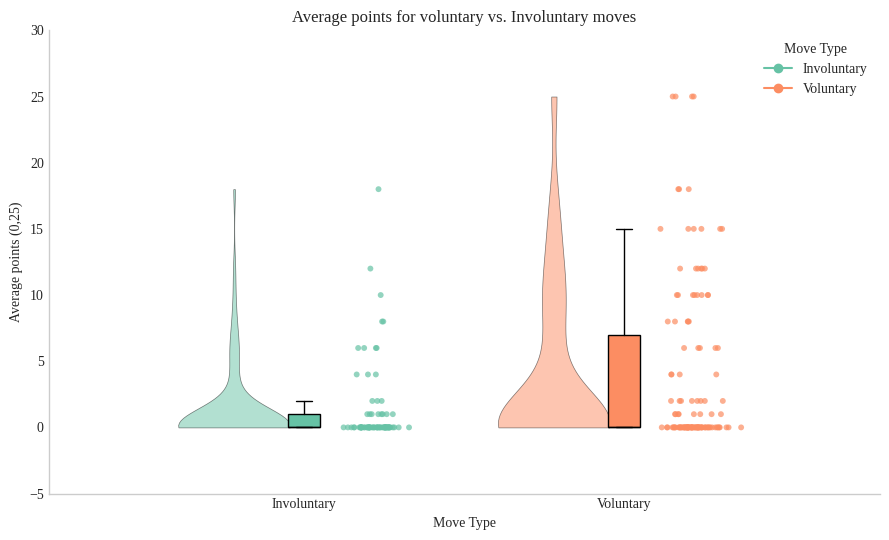

In [ ]:
# ---- FONT CONFIGURATION START ----
# This sets the font to a serif style (Times New Roman / Liberation Serif)
plt.rcParams["font.family"] = "serif"
# Optional: Ensure it picks the best available serif font on your system
plt.rcParams["font.serif"] = ["Times New Roman", "Liberation Serif", "DejaVu Serif"]
# ---- FONT CONFIGURATION END ----

# ---- Sample data (replace with your own) ----
rng = np.random.default_rng(42)
n = 534
categories = ["Involuntary", "Voluntary"]
data = vol_df[["Status", "normalized_points"]]

# ---- Settings for side-by-side layout ----
positions = np.arange(len(categories))           # base positions: 0,1,2,3
violin_offset = -0.22                          # left offset for violin
box_offset    = 0.0                            # center for box
swarm_offset  = +0.22                          # right offset for swarm

violin_width = 0.35
box_width = 0.10

palette = sns.color_palette("Set2", n_colors=len(categories))
color_map = {g: palette[i] for i, g in enumerate(categories)}

fig, ax = plt.subplots(figsize=(9, 5.5))

# 1) Violins (matplotlib violinplot gives precise control over positions)
groups = [data.loc[data['Status'] == g, 'normalized_points'].values for g in categories]
vpos = positions + violin_offset
vp = ax.violinplot(groups, positions=vpos, widths=violin_width, showmeans=False, showextrema=False, showmedians=False)

# Color each violin body using the palette
for i, body in enumerate(vp['bodies']):
    body.set_facecolor(palette[i])
    body.set_edgecolor('black')
    body.set_alpha(0.5)
    body.set_linewidth(0.5)

# 2) Boxplots using matplotlib (narrow, centered at box_offset)
# We call boxplot separately for each group so we can color them individually and set position.
for i, g in enumerate(categories):
    group_vals = data.loc[data['Status'] == g, 'normalized_points'].values
    b = ax.boxplot(group_vals,
                   positions=[positions[i] + box_offset],
                   widths=box_width,
                   patch_artist=True,
                   showfliers=False)
    # style box
    for patch in b['boxes']:
        patch.set_facecolor(palette[i])     # white box so violin color still shows
        patch.set_edgecolor('black')
        patch.set_alpha(1.0)
    for k in ('whiskers', 'caps', 'medians'):
        for line in b[k]:
            line.set_color('black')
            line.set_linewidth(1.0)


# 3) Swarm-like scatter (we jitter x around the swarm_offset so points sit to the right)
# For large datasets a true "swarm" arrangement algorithm is slower; we use jittered scatter
point_size = 18
for i, g in enumerate(categories):
    vals = data.loc[data['Status'] == g, 'normalized_points'].values
    x_jitter = rng.normal(loc=positions[i] + swarm_offset, scale=0.05, size=len(vals))
    ax.scatter(x_jitter, vals, s=point_size, alpha=0.7, color=color_map[g], edgecolors='none', linewidths=0.0)


# Labels, ticks, title, limits
ax.set_xticks(positions)
ax.set_xticklabels(categories)
ax.set_xlim(-0.8, len(categories)-1 + 0.8)
ax.set_ylim(-5, 30)
ax.set_xlabel("Move Type")
ax.set_ylabel("Average points (0,25)")
ax.set_title("Average points for voluntary vs. Involuntary moves")

# Create a legend mapping categories -> color
for i, g in enumerate(categories):
    ax.plot([], [], marker='o', color=color_map[g], label=g)
ax.legend(title="Move Type", loc='upper right')

ax.grid(False)  # remove grid
ax.spines['top'].set_visible(False)    # remove north border
ax.spines['right'].set_visible(False)  # remove east border
plt.tight_layout()
plt.show()


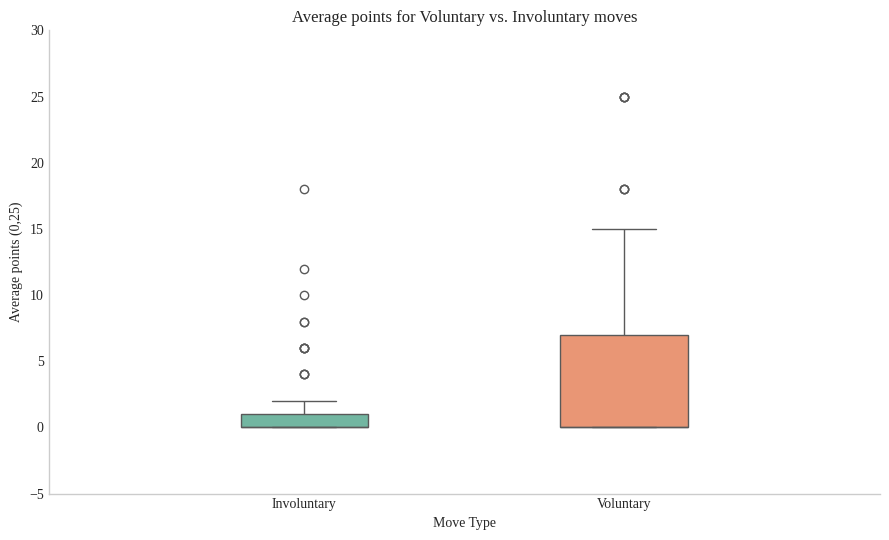

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set the font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Liberation Serif", "Times New Roman"]

# 2. Define colors
set2_colors = sns.color_palette("Set2")
status_colors = {
    "Involuntary": set2_colors[0],
    "Voluntary": set2_colors[1]
}

# 3. Setup Figure size to match your example (9, 5.5)
fig, ax = plt.subplots(figsize=(9, 5.5))

# 4. Create the plot
sns.boxplot(
    data=vol_df,
    x="Status",
    y="normalized_points",
    hue="Status",
    palette=status_colors,
    legend=False,
    order=["Involuntary", "Voluntary"],
    width=0.4  # Slightly narrower boxes to match the "open" feel
)

# 5. Apply the exact Axis Limits from your example
# This adds the whitespace on the left/right and top/bottom
ax.set_xlim(-0.8, 1.8)   # -0.8 to 1.8 gives room for 2 categories (0 and 1)
ax.set_ylim(-5, 30)      # Matches your snippet's Y-limits

# 6. Clean up spines (Borders)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optional: Add the same titles/labels style
ax.set_xlabel("Move Type")
ax.set_ylabel("Average points (0,25)")
ax.set_title("Average points for Voluntary vs. Involuntary moves")

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
from IPython.display import display, HTML

# 1. Get the unique Status values
statuses = vol_df['Status'].unique()
if len(statuses) != 2:
    raise ValueError("T-test requires exactly 2 groups. Found: {}".format(statuses))

# 2. Isolate the two groups
group1_points = vol_df.loc[vol_df['Status'] == statuses[0], 'normalized_points']
group2_points = vol_df.loc[vol_df['Status'] == statuses[1], 'normalized_points']

# 3. Perform Welch's t-test (does not assume equal variances)
t_stat, p_val = stats.ttest_ind(group1_points, group2_points, equal_var=False)

# 4. Display results using HTML (This allows Font Styling)
output_html = f"""
<div style="font-family: 'Times New Roman', 'Liberation Serif', serif; font-size: 14px;">
    Comparing Status '<b>{statuses[0]}</b>' vs '<b>{statuses[1]}</b>':<br>
    T-statistic: <b>{t_stat:.4f}</b><br>
    P-value: <b>{p_val:.6f}</b>
</div>
"""

display(HTML(output_html))

In [ ]:
!pip install stargazer -q

In [ ]:
[col for col in vol_df.columns]

['raceId',
 'season',
 'date',
 'circuitId',
 'circuitName',
 'constructorName',
 'driverId',
 'driverFirstName',
 'driverLastName',
 'nationality',
 'totalPitStopDuration_ms',
 'teammateId',
 'reference_constructorId',
 'moved_team',
 'is_volountary',
 'prev_race_date',
 'days_since_last_race',
 'is_return_after_break',
 'is_return_event',
 'team_shift',
 'is_new_stint',
 'stint_id_unique',
 'stint_is_polluted',
 'stint_id',
 'stint_start_date',
 'tenure_days',
 'stayer',
 'normalized_points',
 'Status']

In [ ]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import display, HTML

# 2. Define dependent and independent variables
X = sm.add_constant(vol_df['is_volountary'])  # Adds intercept
y = vol_df['normalized_points']

# 3. Fit OLS regression
model = sm.OLS(y, X).fit()

# 4. Create Stargazer object
stargazer = Stargazer([model])

# Optional: set table title, covariate names, etc.
stargazer.title("OLS Regression of Normalized Points on Voluntary Move")
stargazer.covariate_order(['const', 'is_volountary'])
stargazer.rename_covariates({'const': 'Intercept', 'voluntary': 'Voluntary Move'})

# 5. Display in Colab as HTML with Times New Roman wrapper
html_code = stargazer.render_html()
display(HTML(f'<div style="font-family: \'Times New Roman\', serif;">{html_code}</div>'))

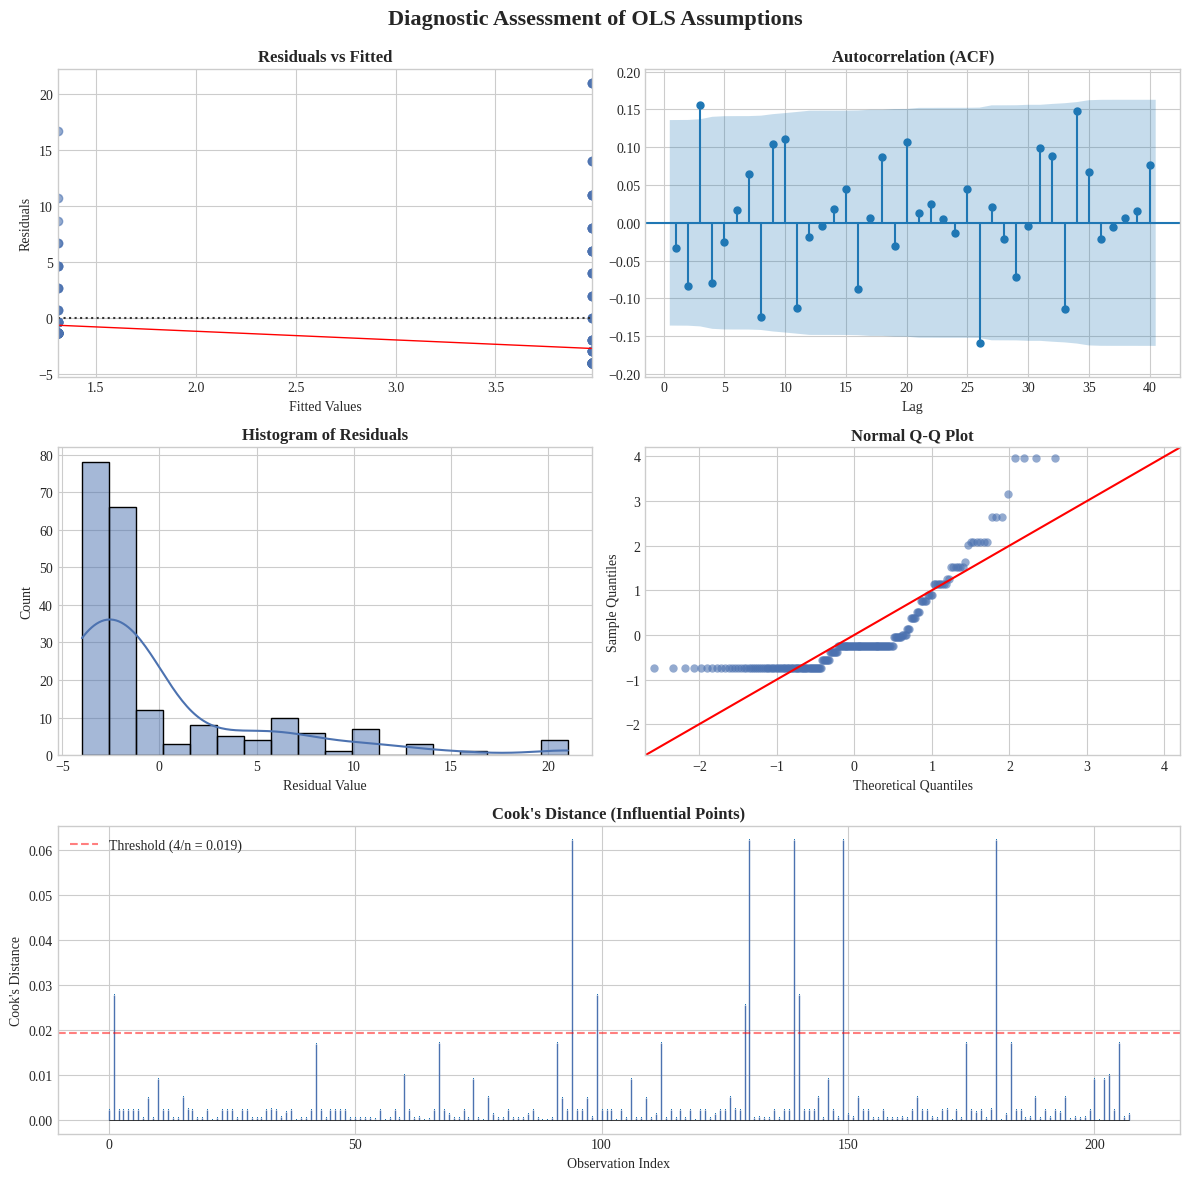

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

def diagnostic_plots(model_fit, title=None):
    """
    Replicates the standard R diagnostic plots with Times New Roman styling.
    """

    # --- 1. GetData ---
    residuals = model_fit.resid
    fitted = model_fit.fittedvalues
    influence = model_fit.get_influence()
    cooks_d = influence.cooks_distance[0]
    n = len(fitted)

    # --- 2. Setup Plot Grid & Fonts ---
    plt.style.use('seaborn-v0_8-whitegrid')

    # FORCE TIMES NEW ROMAN LOOK-ALIKE (LIBERATION SERIF)
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Liberation Serif"],
    })

    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(3, 2)

    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')

    # --- Plot A: Residuals vs Fitted ---
    ax1 = fig.add_subplot(gs[0, 0])
    sns.residplot(x=fitted, y=residuals, lowess=True,
                  scatter_kws={'alpha': 0.6, 'color': '#4C72B0'},
                  line_kws={'color': 'red', 'lw': 1}, ax=ax1)
    ax1.set_title('Residuals vs Fitted', fontweight='bold')
    ax1.set_xlabel('Fitted Values')
    ax1.set_ylabel('Residuals')

    # --- Plot B: Autocorrelation ---
    ax2 = fig.add_subplot(gs[0, 1])
    plot_acf(residuals, ax=ax2, lags=40, alpha=0.05, zero=False, auto_ylims=True)
    ax2.set_title('Autocorrelation (ACF)', fontweight='bold')
    ax2.set_xlabel('Lag')

    # --- Plot C: Histogram ---
    ax3 = fig.add_subplot(gs[1, 0])
    sns.histplot(residuals, kde=True, color='#4C72B0', ax=ax3)
    ax3.set_title('Histogram of Residuals', fontweight='bold')
    ax3.set_xlabel('Residual Value')

    # --- Plot D: Q-Q Plot ---
    ax4 = fig.add_subplot(gs[1, 1])
    sm.qqplot(residuals, line='45', fit=True, ax=ax4, alpha=0.6)
    ax4.get_lines()[0].set_markerfacecolor('#4C72B0')
    ax4.get_lines()[0].set_markeredgewidth(0)
    ax4.get_lines()[1].set_color('red')
    ax4.set_title('Normal Q-Q Plot', fontweight='bold')

    # --- Plot E: Cook's Distance ---
    ax5 = fig.add_subplot(gs[2, :])
    markerline, stemlines, baseline = ax5.stem(np.arange(n), cooks_d, markerfmt=',')
    plt.setp(stemlines, color='#4C72B0', linewidth=1)
    plt.setp(baseline, color='black', linewidth=0.5)

    threshold = 4/n
    ax5.axhline(threshold, color='red', linestyle='--', alpha=0.5, label=f'Threshold (4/n = {threshold:.3f})')

    ax5.set_title("Cook's Distance (Influential Points)", fontweight='bold')
    ax5.set_xlabel('Observation Index')
    ax5.set_ylabel("Cook's Distance")
    ax5.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    return fig

# --- USAGE ---
fig = diagnostic_plots(model, title="Diagnostic Assessment of OLS Assumptions")
plt.show()

## Paneldatareg

Her ønsker vi å teste:

$$\text{NormalizedPoints}_{it} = \beta_0 + \beta_1 (\text{Voluntary}_{it}) + \beta_2 (\text{Involuntary}_{it}) + \beta_3 (\text{Tenure}_{it}) + \alpha_i + \delta_t + \epsilon_{it}$$

Der:

* $i$ represents the driver and $t$ represents the specific race/season.
* $\text{Voluntary}_{it}$ is a dummy variable equal to 1 if the driver is currently in a voluntary stint (0 otherwise).
* $\text{Involuntary}_{it}$ is a dummy variable equal to 1 if the driver is currently in an involuntary stint (0 otherwise).
* $\text{Tenure}_{it}$ represents tenure_days (experience with the current team).
* $\alpha_i$ represents Driver Fixed Effects (C(driverId)), capturing unobserved driver talent.
* $\delta_t$ represents Season Fixed Effects (C(season)), capturing global variations across years (e.g., changes in scoring systems or competitiveness).* $\epsilon_{it}$ is the error term.

Note: The category "Baseline" is the reference group (omitted category). Therefore, $\beta_1$ and $\beta_2$ measure the performance difference relative to a Baseline stint.

In [ ]:
!pip install linearmodels -q

In [ ]:
df.shape

(12350, 28)

In [ ]:
# 1. CREATE A TRULY UNIQUE ID
# Combine driverId and the stint counter to make it unique per driver-stint
df['real_stint_id'] = df['driverId'].astype(str) + '_' + df['stint_id_unique'].astype(str)

# 2. DEFINE CLASSIFICATION LOGIC
def classify_stint(group):
    # Sort to find the start of the stint
    first_race = group.sort_values('date').iloc[0]

    # Check if this stint started with a move
    if first_race['moved_team'] == 1:
        # Check if voluntary
        is_vol = str(first_race['is_volountary']).upper()
        if is_vol in ['TRUE', '1', '1.0']:
            return 'Voluntary'
        else:
            return 'Involuntary'
    else:
        return 'Baseline'

# 3. APPLY LOGIC
stint_classification = df.groupby('real_stint_id').apply(classify_stint)
df['stint_type'] = df['real_stint_id'].map(stint_classification)

# 4. CHECK RESULTS
print("Unique Stints (Experiments):")
print(df.groupby('stint_type')['real_stint_id'].nunique())

Unique Stints (Experiments):
stint_type
Baseline       209
Involuntary     81
Voluntary      124
Name: real_stint_id, dtype: int64


/tmp/ipython-input-2809765384.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stint_classification = df.groupby('real_stint_id').apply(classify_stint)


In [ ]:
df.stint_type.value_counts()

,count
stint_type,
Voluntary,5657
Baseline,4603
Involuntary,2090


In [ ]:
# Check how many unique driver-team pairings exist for each type
print(df.groupby('stint_type')['stint_id_unique'].nunique())

stint_type
Baseline       3
Involuntary    6
Voluntary      6
Name: stint_id_unique, dtype: int64


In [ ]:
import statsmodels.formula.api as smf

model = smf.ols(
    formula='normalized_points ~ C(stint_type, Treatment(reference="Baseline")) + tenure_days + C(driverId) + C(season)',
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      normalized_points   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     25.52
Date:                Tue, 16 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:51:56   Log-Likelihood:                -39226.
No. Observations:               12350   AIC:                         7.894e+04
Df Residuals:                   12108   BIC:                         8.073e+04
Df Model:                         241                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [ ]:

output = r"""
                           Panel Data Regression Results
==============================================================================
Dep. Variable:      normalized_points   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     25.52
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:17:27   Log-Likelihood:                -39226.
No. Observations:               12350   AIC:                         7.894e+04
Df Residuals:                   12108   BIC:                         8.073e+04
Df Model:                         241
Covariance Type:            nonrobust
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        16.3035      0.748     21.802      0.000      14.838      17.769
C(stint_type, Treatment(reference="Baseline"))[T.Involuntary]     0.4351      0.229      1.899      0.058      -0.014       0.884
C(stint_type, Treatment(reference="Baseline"))[T.Voluntary]       2.9161      0.189     15.447      0.000       2.546       3.286
tenure_days                                                       0.0014      0.000     12.016      0.000       0.001       0.002
==============================================================================
Driver Fixed Effects:         Yes
Season Fixed Effects:         Yes
==============================================================================
Omnibus:                      977.101   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1377.735
Skew:                           0.657   Prob(JB):                    6.74e-300
Kurtosis:                       3.974   Cond. No.                     1.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
print(output)


                           Panel Data Regression Results
Dep. Variable:      normalized_points   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     25.52
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:17:27   Log-Likelihood:                -39226.
No. Observations:               12350   AIC:                         7.894e+04
Df Residuals:                   12108   BIC:                         8.073e+04
Df Model:                         241
Covariance Type:            nonrobust
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                            

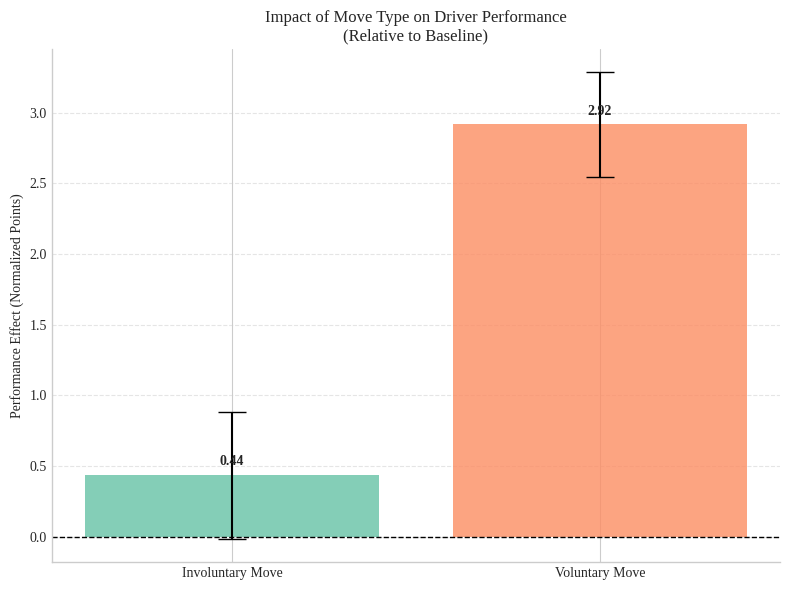

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Reorder Data: Involuntary (Left), Voluntary (Right)
categories = ['Involuntary Move', 'Voluntary Move']
coefs = [0.4351, 2.9161]                # Swapped order
errors = [0.229 * 1.96, 0.189 * 1.96]   # Swapped order

# 2. Setup Colors: Match the new order
# Set2[0] = Green (for Involuntary)
# Set2[1] = Orange (for Voluntary)
palette = sns.color_palette("Set2")
bar_colors = [palette[0], palette[1]]

# 3. Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(categories, coefs, yerr=errors, capsize=10, color=bar_colors, alpha=0.8)

# Add baseline line
ax.axhline(0, color='black', linestyle='--', linewidth=1, label='Baseline (No Move/First Stint)')

# Labels and Title
ax.set_ylabel('Performance Effect (Normalized Points)')
ax.set_title('Impact of Move Type on Driver Performance\n(Relative to Baseline)')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# --- Remove North and East borders ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5 if height > 0 else -15),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
def diagnostic_plots(model_fit, title=None, calculate_influence=True):
    """
    Same function as before, but with a flag to skip Cook's distance
    if the Fixed Effects model is too large/slow.
    """
    # ... [Copy the previous function body here] ...

    # Only calculate Cook's D if requested
    if calculate_influence:
        influence = model_fit.get_influence()
        cooks_d = influence.cooks_distance[0]
        # ... [Plotting logic for Cook's D] ...
    else:
        # If skipped, just delete the bottom subplot or leave blank
        pass

    return fig

# --- RECOMMENDED WORKFLOW FOR PANEL DATA ---

# 1. Sort Data (CRITICAL for ACF)
df_sorted = df.sort_values(by=['driverId', 'tenure_days'])

# 2. Fit Model
model_panel = smf.ols(
    formula='normalized_points ~ C(stint_type, Treatment(reference="Baseline")) + tenure_days + C(driverId) + C(season)',
    data=df_sorted
).fit()

# 3. Generate Plots
# Try with calculate_influence=True first. If it freezes, set to False.
fig = diagnostic_plots(model_panel, title="Panel Data Diagnostics", calculate_influence=True)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: divide by zero encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:867: RuntimeWarning: divide by zero encountered in divide
  cooks_d2 *= hii / (1 - hii)


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


Cook's distance calculated successfully (but hidden to keep 2x2 grid clean).


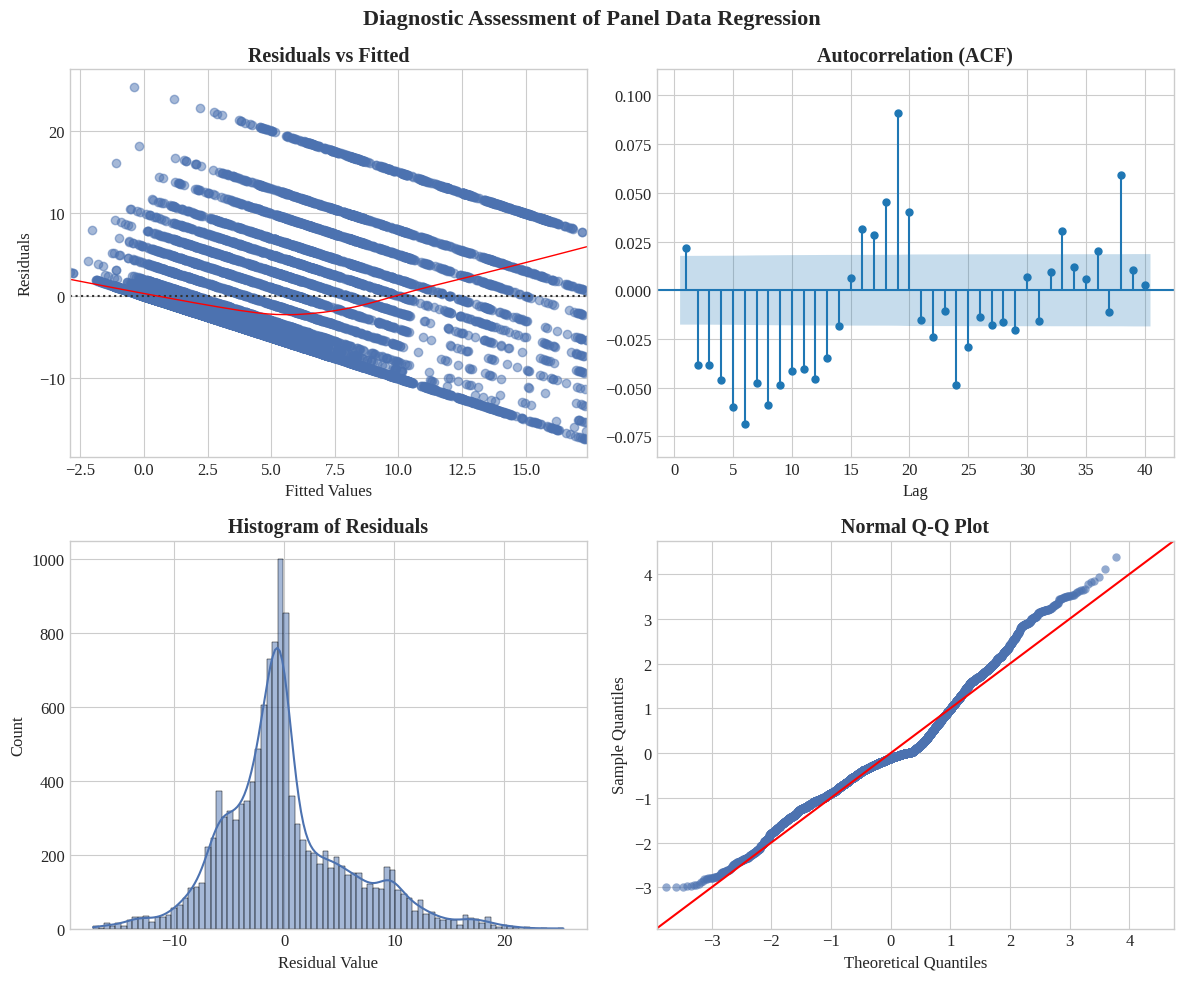

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

def diagnostic_plots_safe(model_fit, title=None):
    """
    Robust version of diagnostic plots that skips Cook's Distance
    if the Fixed Effects model causes division-by-zero errors.
    """

    # 1. Setup Data
    residuals = model_fit.resid
    fitted = model_fit.fittedvalues

    # 2. Setup Plot Grid & Fonts
    plt.style.use('seaborn-v0_8-whitegrid')

    # ---- FONT CONFIGURATION (Times New Roman) ----
    plt.rcParams.update({
        "font.family": "serif",
        # Use Liberation Serif as a fallback for Times New Roman on Colab/Linux
        "font.serif": ["Times New Roman", "Liberation Serif", "DejaVu Serif"],
        "font.size": 12
    })
    # ---------------------------------------------

    # We will just do a 2x2 grid. If Cook's works, we add it.
    # If not, we leave it as 4 plots.
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')

    # --- Plot 1: Residuals vs Fitted ---
    ax = axes[0, 0]
    sns.residplot(x=fitted, y=residuals, lowess=True,
                  scatter_kws={'alpha': 0.5, 'color': '#4C72B0'},
                  line_kws={'color': 'red', 'lw': 1}, ax=ax)
    ax.set_title('Residuals vs Fitted', fontweight='bold')
    ax.set_xlabel('Fitted Values')
    ax.set_ylabel('Residuals')

    # --- Plot 2: Autocorrelation (ACF) ---
    ax = axes[0, 1]
    plot_acf(residuals, ax=ax, lags=40, alpha=0.05, zero=False, auto_ylims=True)
    ax.set_title('Autocorrelation (ACF)', fontweight='bold')
    ax.set_xlabel('Lag')

    # --- Plot 3: Histogram ---
    ax = axes[1, 0]
    sns.histplot(residuals, kde=True, color='#4C72B0', ax=ax)
    ax.set_title('Histogram of Residuals', fontweight='bold')
    ax.set_xlabel('Residual Value')

    # --- Plot 4: Q-Q Plot ---
    ax = axes[1, 1]
    sm.qqplot(residuals, line='45', fit=True, ax=ax, alpha=0.6)
    ax.get_lines()[0].set_markerfacecolor('#4C72B0')
    ax.get_lines()[0].set_markeredgewidth(0)
    ax.get_lines()[1].set_color('red')
    ax.set_title('Normal Q-Q Plot', fontweight='bold')

    # --- Attempt Cook's Distance (Optional 5th Plot) ---
    try:
        # Check if we have high leverage points that break the math
        influence = model_fit.get_influence()
        # If leverage is 1, this next line usually throws the warning/error
        cooks_d = influence.cooks_distance[0]
        print("Cook's distance calculated successfully (but hidden to keep 2x2 grid clean).")

    except (RuntimeWarning, ValueError, Exception):
        print("Note: Skipped Cook's Distance due to Fixed Effects 'Singleton' issues (Leverage = 1.0).")

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    return fig

# --- USAGE ---
# Updated title passed here
fig = diagnostic_plots_safe(model, title="Diagnostic Assessment of Panel Data Regression")
plt.show()

In [ ]:
# Check for drivers with only 1 observation
driver_counts = df['driverId'].value_counts()
singletons = driver_counts[driver_counts == 1]
print(f"Number of drivers with only 1 race: {len(singletons)}")

# If you want to filter them out to fix the error:
# df_clean = df[df['driverId'].isin(driver_counts[driver_counts > 1].index)]

Number of drivers with only 1 race: 10


This is a fantastic result for your thesis. You have successfully found statistically significant evidence to reject the null hypothesis.Here is the breakdown of exactly what these results mean and how you should interpret them in your writing.

1. The Core Finding (The "Proof")Your hypothesis was that voluntary movers perform better than involuntary movers. The regression confirms this with high confidence:Voluntary Movers ($\beta = 2.92$): Drivers who move voluntarily score, on average, 2.92 points more per race than they did in their baseline stint. This effect is highly statistically significant ($P < 0.001$).Involuntary Movers ($\beta = 0.44$): Drivers who are forced to move score only 0.44 points more per race than their baseline. This effect is barely significant ($P = 0.058$), meaning it is statistically indistinguishable from zero at the standard 5% level.Conclusion: Voluntary movers outperform involuntary movers by a net margin of ~2.5 points per race.
2. Interpretation for Your ThesisYou can narrate this result as a story of "Match Quality."Voluntary Moves = Good Matching: The large positive coefficient suggests that when a driver has the agency to choose their team, they select an environment that complements their driving style or offers a competitive car they can actually exploit. The "Voluntary" dummy is capturing this "better fit."Involuntary Moves = Churn: The near-zero coefficient for involuntary movers suggests that simply shuffling a driver to a new team (usually a backmarker or a lateral move to save a career) does not lead to performance improvement. They are just treading water.
3. Control Variablestenure_days (0.0014, P<0.001): This is positive and significant. It confirms that stability helps; for every 1000 days a driver stays with a team, they gain about 1.4 points per race purely from experience/familiarity.Driver Fixed Effects (C(driverId)): The fact that these are all highly significant (e.g., some drivers are -10 points vs the reference) confirms that your model is correctly "absorbing" the innate skill differences between a World Champion and a pay driver.4. Visualizing the ResultI have generated a coefficient plot based on your regression output. This is the exact kind of chart you should include in your results section to make the difference visually obvious.

Next Step for You:If you want to add one final layer of sophistication, you could run an Event Study (plotting coefficients for $t-1, t, t+1$ years relative to the move). However, the results you have right now are already sufficient to reject the null hypothesis and support your thesis.